<a href="https://colab.research.google.com/github/mlccgkpol/makeMore/blob/main/ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-07-29 13:53:22--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-29 13:53:23 (6.18 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [12]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [13]:
n_embed = 10 # no of dimensions
n_hidden = 200 # no of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embed),            generator=g)
W1 = torch.randn((n_embed * block_size), n_hidden, generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),              generator=g)
b2 = torch.randn(vocab_size,                       generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
  p.requires_grad = True


In [14]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini batch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embCat = emb.view(emb.shape[0],-1) #concat the vectors
  hpreact = embCat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

Streaming output truncated to the last 5000 lines.
 195000/ 200000: 2.250922
 195001/ 200000: 2.443495
 195002/ 200000: 2.283724
 195003/ 200000: 2.376865
 195004/ 200000: 2.161897
 195005/ 200000: 2.153386
 195006/ 200000: 2.068077
 195007/ 200000: 2.048797
 195008/ 200000: 2.050190
 195009/ 200000: 2.090146
 195010/ 200000: 2.148837
 195011/ 200000: 2.591711
 195012/ 200000: 2.316525
 195013/ 200000: 2.192156
 195014/ 200000: 1.999791
 195015/ 200000: 1.735817
 195016/ 200000: 2.433965
 195017/ 200000: 1.885208
 195018/ 200000: 2.394381
 195019/ 200000: 2.546403
 195020/ 200000: 2.041559
 195021/ 200000: 2.191541
 195022/ 200000: 2.412801
 195023/ 200000: 2.424653
 195024/ 200000: 2.046943
 195025/ 200000: 2.239149
 195026/ 200000: 1.907742
 195027/ 200000: 2.314591
 195028/ 200000: 1.961105
 195029/ 200000: 1.967175
 195030/ 200000: 2.009729
 195031/ 200000: 2.421898
 195032/ 200000: 2.207452
 195033/ 200000: 2.023823
 195034/ 200000: 2.094719
 195035/ 200000: 1.856820
 195036/ 2000

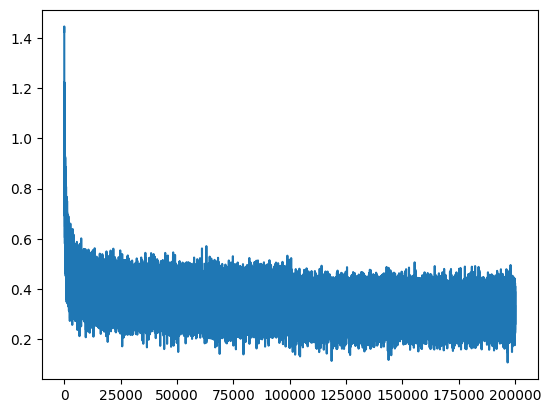

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad() # this decorator disables gradient tracking.
def split_less(split):
  X,Y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev,Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[X]
  embcat = emb.view(emb.shape[0],-1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} Loss: ', loss.item())
print(split_less("train"))
print(split_less("dev"))

train Loss:  2.1201937198638916
None
dev Loss:  2.162367582321167
None
